In [207]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
IMAGE_DIR_TRAIN = 'focas/images/train/'
IMAGE_DIR_TEST = 'focas/images/fullres_test_all/'

CSV_INPUT_TRAIN = 'focas/annotations/train_20_labels.csv'
CSV_INPUT_TEST = 'focas/annotations/test_20_labels.csv'

CSV_INPUT_TRAIN2 = 'annotations/train_full_labels.csv'
CSV_INPUT_TEST2 = 'annotations/test_full_labels.csv'
OUTPUT = 'focas/output/'

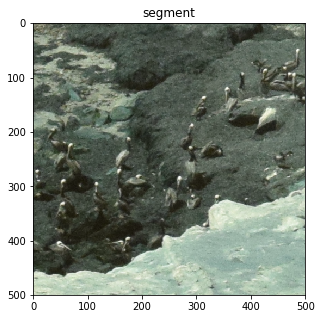

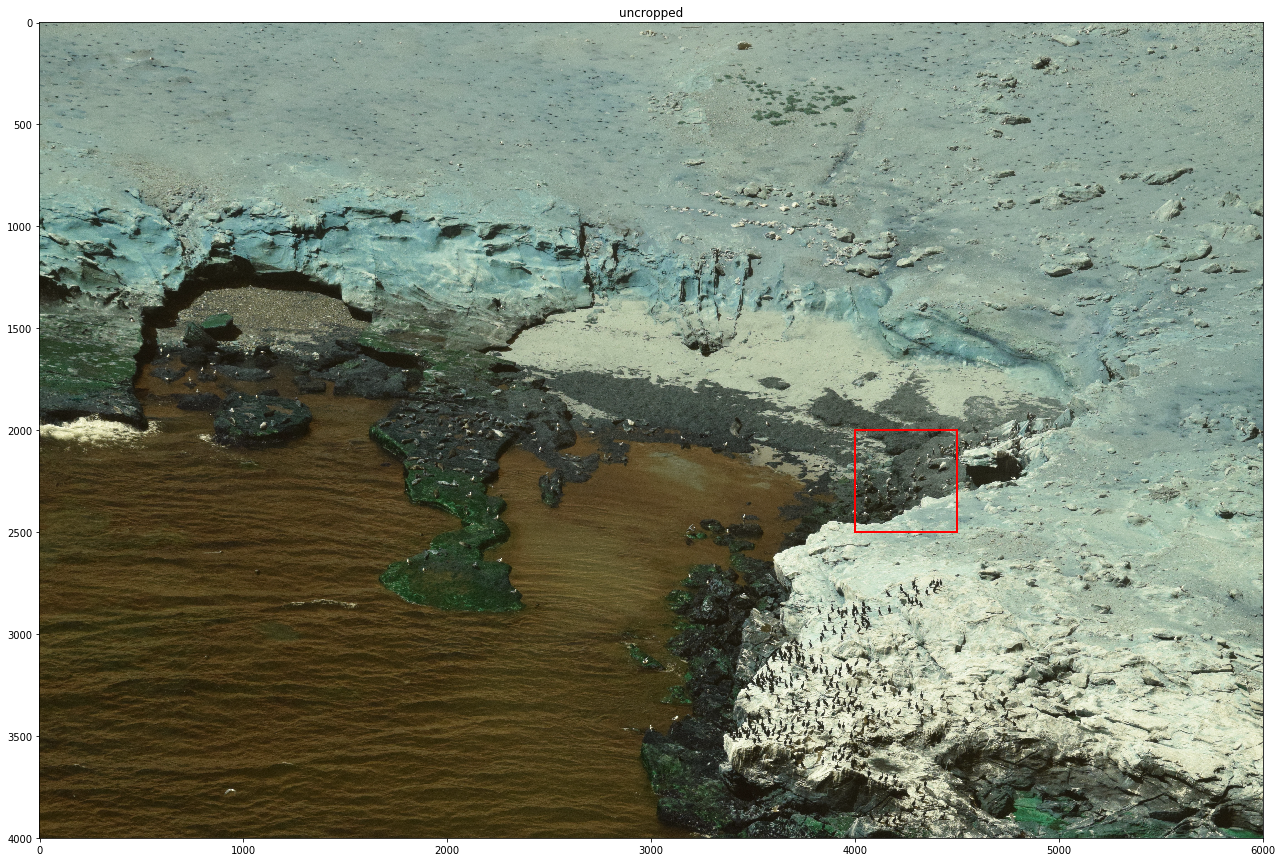

In [199]:
open_image = cv2.imread('DSC_1783.JPG')
cropped = open_image[2000:2000+500, 4000:4000+500]
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(cropped)
plt.title('segment')
plt.show()
cv2.line(open_image, (4000, 2000), (4500, 2000), (255, 0, 0), 10)
cv2.line(open_image, (4500, 2000), (4500, 2500), (255, 0, 0), 10)
cv2.line(open_image, (4500, 2500), (4000, 2500), (255, 0, 0), 10)
cv2.line(open_image, (4000, 2500), (4000, 2000), (255, 0, 0), 10)
plt.rcParams["figure.figsize"] = (30,15)
plt.imshow(open_image)
plt.title('uncropped')
plt.show()

In [209]:
def crop(image_dir, csv_data, output_dir):
    data = pd.read_csv(csv_data)
    files_train = set(data.filename)
    for image in files_train:
        imagepath = image_dir + image
        open_image = cv2.imread(imagepath)
        for i in range(0, 6000, 500):
            for j in range(0, 4000, 500):
                imagepath2 = OUTPUT + output_dir + str(i) + '_' + str(j) + '_' + image
                cropped = open_image[j:j+500, i:i+500]
                cv2.imwrite(imagepath2,cropped)

#crop(IMAGE_DIR_TRAIN, CSV_INPUT_TRAIN, '500_20/')
#crop(IMAGE_DIR_TEST, CSV_INPUT_TEST, '500_20/')

#crop(IMAGE_DIR_TRAIN, CSV_INPUT_TRAIN2, '500_train/')
crop(IMAGE_DIR_TEST, CSV_INPUT_TEST2, '500_test/')
#crop(IMAGE_DIR_TRAIN, CSV_INPUT_TRAIN2, '500_all/')
#crop(IMAGE_DIR_TEST, CSV_INPUT_TEST2, '500_all/')

In [117]:
df1 = pd.read_csv(CSV_INPUT_TRAIN2)
df2 = pd.read_csv(CSV_INPUT_TEST2)
df = pd.concat([df1, df2])
df.describe()

,width,height,xmin,ymin,xmax,ymax
count,4640.0,4640.0,4640.000000,4640.000000,4640.000000,4640.000000
mean,6000.0,4000.0,2697.486207,2002.862500,2812.353448,2080.116379
std,0.0,0.0,1441.819765,768.656014,1443.952281,771.280194
min,6000.0,4000.0,1.000000,1.000000,27.000000,38.000000
25%,6000.0,4000.0,1527.000000,1541.000000,1628.250000,1631.750000
50%,6000.0,4000.0,2604.000000,2098.500000,2704.000000,2169.500000
75%,6000.0,4000.0,3766.250000,2475.250000,3875.000000,2542.250000
max,6000.0,4000.0,5972.000000,3942.000000,6000.000000,4000.000000


In [120]:
#df = pd.concat([df1, df2])
df = df1
df.width = 500
df.height = 500
dims = []
for i in range(0, 6000, 500):
        for j in range(0, 4000, 500):
            df_new = df.copy()
            df_new['filename'] = df_new['filename'].apply(lambda x: str(i) + '_' + str(j) + '_' + x)
            dims.append(df_new)
df = pd.concat(dims)
all_files = set(df.filename)

def isInRange(num, low, up):
    return (num >= low and num <= up)

def hasBoundingBox(s, xmin, ymin, xmax, ymax):
    ij = [int(s) for s in s.split('_') if s.isdigit()]
    min_x = ij[0]
    min_y = ij[1]
    max_x = ij[0] + 500
    max_y = ij[1] + 500
    xmin_f = isInRange(xmin, min_x, max_x)
    xmax_f = isInRange(xmax, min_x, max_x)
    ymin_f = isInRange(ymin, min_y, max_y)
    ymax_f = isInRange(ymax, min_y, max_y)
    return (xmin_f or xmax_f) and (ymin_f or ymax_f)

df['hasBoundingBox'] = df.apply(lambda row: hasBoundingBox(row['filename'], row['xmin'], row['ymin'], row['xmax'], row['ymax']), axis=1)
df = df[df['hasBoundingBox'] == True]
del df['hasBoundingBox']
toKeep = set(df.filename)

def fixBounds(num):
    if num >= 500:
        return 500
    elif num <= 0:
        return 0
    else:
        return num
    
def coordinates(s):
    return [int(s) for s in s.split('_') if s.isdigit()]

df['xmin2'] = df.apply(lambda row: row['xmin'] - coordinates(row['filename'])[0], axis=1)
df['xmax2'] = df.apply(lambda row: row['xmax'] - coordinates(row['filename'])[0], axis=1)
df['ymin2'] = df.apply(lambda row: row['ymin'] - coordinates(row['filename'])[1], axis=1)
df['ymax2'] = df.apply(lambda row: row['ymax'] - coordinates(row['filename'])[1], axis=1)

df['xmin3'] = df.apply(lambda row: fixBounds(row['xmin2']), axis=1)
df['xmax3'] = df.apply(lambda row: fixBounds(row['xmax2']), axis=1)
df['ymin3'] = df.apply(lambda row: fixBounds(row['ymin2']), axis=1)
df['ymax3'] = df.apply(lambda row: fixBounds(row['ymax2']), axis=1)
 
df['xmin'] = df['xmin3']
df['xmax'] = df['xmax3']
df['ymin'] = df['ymin3']
df['ymax'] = df['ymax3']
    
del df['xmin3']
del df['xmax3']
del df['ymin3']
del df['ymax3']
del df['xmin2']
del df['xmax2']
del df['ymin2']
del df['ymax2']
    
#df.to_csv(OUTPUT + 'train_labels' + ".csv", sep=',', index=False)

In [121]:
#import os
#toDelete = [file for file in all_files if file not in toKeep]
#for deletable in toDelete:
#    os.remove(OUTPUT + "500_train/" + deletable)

In [123]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
337,0_500_DSC_1786.JPG,500,500,foca,286,8,331,24
447,0_500_DSC_3566.JPG,500,500,foca,63,484,137,500
450,0_500_DSC_3566.JPG,500,500,foca,227,405,348,471
451,0_500_DSC_3566.JPG,500,500,foca,144,456,214,500
452,0_500_DSC_3566.JPG,500,500,foca,224,476,332,500


Text(0.5,1,'foca')

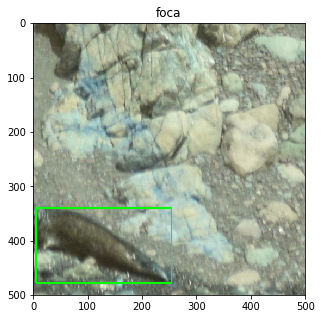

In [192]:
num = 38
open_image = cv2.imread('focas/images/' + "500_train/" + df["filename"].iloc[num])
cv2.line(open_image, (df["xmin"].iloc[num], df["ymin"].iloc[num]), (df["xmax"].iloc[num], df["ymin"].iloc[num]), (0,255,0), 2)
cv2.line(open_image, (df["xmin"].iloc[num], df["ymax"].iloc[num]), (df["xmax"].iloc[num], df["ymax"].iloc[num]), (0,255,0), 2)
cv2.line(open_image, (df["xmin"].iloc[num], df["ymin"].iloc[num]), (df["xmin"].iloc[num], df["ymax"].iloc[num]), (0,255,0), 2)
cv2.line(open_image, (df["xmax"].iloc[num], df["ymin"].iloc[num]), (df["xmax"].iloc[num], df["ymax"].iloc[num]), (0,255,0), 2)
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(open_image)
plt.title('foca')